# Analyzing Lucio's galaxies from Ponos zoom-in simulations

``` 
* PonosQ (the smaller galaxy discussed in Fiacconi et al. 2016)
* PonosV (the larger galaxy)
* PonosSB (the same as PonosV but with a different stellar feedback scheme). 

Each archive contains 50 files. The files correspond to 50 lines of sight. Each file contains a 512x512 2D numpy array that represents the stellar surface density map. The data stored in the array are in units of Msol/kpc^2. The physical extent of the maps is 400 physical kpc, i.e. from -200 to 200 kpc in both x and y. All the data are at z=0.408 and I removed the subhaloes according to the size of their virial/tidal radius.
```
$H_0=70.2 km s^{-1} Mpc^{-1}$

no AGN feedback


In [1]:
import numpy as np
import h5py
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import gridspec
from matplotlib import rc
import matplotlib.pylab as plt

plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

import glob
import os
import pickle
import sys

from astropy.table import Table

sys.path.append('/Users/fardila/Documents/GitHub/HSC_vs_hydro/')
from functions import *

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


      +------------------------------------------------------------+
      |             Space Telescope Tables Package                 |
      |                  TABLES Version 3.18.3                     |
      |                                                            |
      |   Space Telescope Science Institute, Baltimore, Maryland   |
      |   Copyright (C) 2014 Association of Universities for       |
      |            Research in Astronomy, Inc.(AURA)               |
      |       See stsdas$copyright.stsdas for terms of use.        |
      |         For help, send e-mail to help@stsci.edu            |
      +------------------------------------------------------------+
tables/:
 fitsio/        tbplot/         tobsolete/      ttools/


      +------------------------------------------------------------+
      |       Space Telescope Science Data Analysis System         |


In [2]:
#HSC profile data
hsc_data='/Users/fardila/Documents/Github/HSC_vs_hydro/Data/HSC/'
hscMedProf_114_116 = np.load(hsc_data+'s16a_wide2_massive_logm100_11.4_11.6.medprof.npy')[0]
hscMedProf_116_118 = np.load(hsc_data+'s16a_wide2_massive_logm100_11.6_11.8.medprof.npy')[0]
hscMedProf_118_120 = np.load(hsc_data+'s16a_wide2_massive_logm100_11.8_12.0.medprof.npy')[0]

#matched by halo mass
ponosv_hsc = np.load(hsc_data+'ponosv_hsc_profiles.npz')
# Array of individual profiles
ponosv_all = ponosv_hsc['profs']
# Average profile 
ponosv_avg = ponosv_hsc['avg']

# Universal RSMA array
sma_hsc = np.arange(0.4, 4.2, 0.01)


In [75]:
# assume b/a = 0.8 = q
q = 0.8
q=1

areas = np.diff([np.pi*(a**8)*q for a in sma_hsc])
areas = np.insert(areas, 0, np.pi*(sma_hsc[0]**8)*q) #include first value
cumulative_isophote_masses = np.log10(np.cumsum(areas*(10**ponosv_avg)))

In [27]:
# From Patel+13 observations (SDSS)
patel10_mprof = Table.read('/Users/fardila/Documents/Github/HSC_vs_hydro/Data/SDSS/patel10_mprof.csv',
                           format='csv')
# z0: z=0.06
# z1: 0.25 < z < 0.50
# z2: 0.50 < z < 1.00
# Z3: 1.00 < z < 1.50
# z4: 1.50 < z < 2.00
# z5: 2.00 < z < 2.50
# z6: 2.50 < z < 3.00


In [28]:
#Ponos files
ponosV_files = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Lucio/PonosV_z0.408_400kpc/'
ponosQ_files = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Lucio/PonosQ_z0.408_400kpc/'
ponosSB_files = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Lucio/PonosSB_z0.408_400kpc/'

In [29]:
physical_size= 400. #kpc
pixel_size = 512. #pixels
pixel_scale = physical_size / pixel_size

In [30]:
glob.glob(ponosV_files+'*.npy')

['/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Lucio/PonosV_z0.408_400kpc/PonosV_z0.408_400kpc_007.npy',
 '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Lucio/PonosV_z0.408_400kpc/PonosV_z0.408_400kpc_013.npy',
 '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Lucio/PonosV_z0.408_400kpc/PonosV_z0.408_400kpc_012.npy',
 '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Lucio/PonosV_z0.408_400kpc/PonosV_z0.408_400kpc_006.npy',
 '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Lucio/PonosV_z0.408_400kpc/PonosV_z0.408_400kpc_010.npy',
 '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Lucio/PonosV_z0.408_400kpc/PonosV_z0.408_400kpc_004.npy',
 '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Lucio/PonosV_z0.408_400kpc/PonosV_z0.408_400kpc_038.npy',
 '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Lucio/PonosV_z0.408_400kpc/PonosV_z0.408_400kpc_039.npy',
 '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Lucio/PonosV_z0.408_400kpc/PonosV_z0.408_400kpc_005.npy',
 '/Users/f

In [31]:
def get_masses_ponos(mass_map, sim_name, pixel_scale, gal_n=0):
    
    #central pixels
    x0=512/2.
    y0=512/2.
    
    #postage mass
    m_post = np.log10(np.sum(mass_map))
    
    #ouput maps
    maps_location='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/Ponos/'

    file_name=sim_name+'_'+str(gal_n)
    fits_prefix = maps_location + file_name
    save_to_fits(mass_map, fits_prefix + '.fits')

    data=mass_map
    suffix=''

    ###########################################################################
    #get background
    bkg = sep.Background(data, bw=10, bh=10, fw=5, fh=5)
    bkg_subtraced_data = data - bkg

    thresh = 50 * bkg.globalrms
    objects = sep.extract(bkg_subtraced_data, thresh, minarea = 100,
                          deblend_nthresh=24, deblend_cont=0.1)

    #find object closest to image center
    obj = find_closest(objects, x0=x0, y0=y0)

    #ellipse parameters
    theta = obj['theta']
    q = obj['b']/ obj['a']

    a_10, a_30, a_100 = (10. / pixel_scale), (30. / pixel_scale), (100. / pixel_scale)
    b_10, b_30, b_100 =  a_10 * q, a_30 * q, a_100 * q



    # plot background-subtracted image
    m, s = np.mean(data), np.std(data)
    fig, ax = plt.subplots()
    im = ax.imshow(data, interpolation='nearest', cmap=plt.get_cmap('viridis'),
                   vmin=m-s, vmax=m+s, origin='lower')

    # plot an ellipse for each object
    e_30 = Ellipse(xy=(obj['x'], obj['y']),
                 width=a_30,
                 height=b_30,
                 angle=theta * 180. / np.pi)
    e_30.set_facecolor('none')
    e_30.set_edgecolor('red')
    ax.add_artist(e_30)

    e_100 = Ellipse(xy=(obj['x'], obj['y']),
                 width=a_100,
                 height=b_100,
                 angle=theta * 180. / np.pi)
    e_100.set_facecolor('none')
    e_100.set_edgecolor('red')
    ax.add_artist(e_100)


    plt.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/ellipses/Ponos/'+file_name)
    plt.clf()

    ###########################################################################
    #2D masses
    flux_10, fluxerr_10, flag_10 = sep.sum_ellipse(data, x0, y0,
                                                   a_10, b_10, theta)
    flux_30, fluxerr_30, flag_30 = sep.sum_ellipse(data, x0, y0,
                                                   a_30, b_30, theta)
    flux_100, fluxerr_100, flag_100 = sep.sum_ellipse(data, x0, y0,
                                                      a_100, b_100, theta)

    ###########################################################################
    #1D masses from galSBP
    iso, iso_bin = galSBP.galSBP(maps_location+file_name+suffix+'.fits',
                                     galX=x0,
                                     galY=y0,
                                     galQ=q,
                                     galPA=theta* 180. / np.pi,
                                     maxSma=250,
                                     iniSma=50.0,
                                     stage=3,
                                     intMode='median',
                                     ellipStep=0.05,
                                     pix=pixel_scale,
                                     zpPhoto=0.0,
                                     isophote=x_isophote,
                                     xttools=x_ttools,
                                     recenter=True,
                                     savePng=False,
                                     verbose=True)


    ###########################################################################
    iso['sma_kpc'] = iso['sma'] * pixel_scale
    iso['intens_kpc']=iso['intens'] / (pixel_scale**2)

    m_1d_10, m_1d_30, m_1d_100 = oneD_mass(iso, 10.), \
                                oneD_mass(iso, 30.), \
                                oneD_mass(iso, 100.)

    #integrated mass from extrapolation
    extrap_mass = extrapolated_1D_mass(iso, 800)



    m_2d_10, m_2d_30, m_2d_100 = np.log10(flux_10), \
                                np.log10(flux_30), \
                                np.log10(flux_100)


    masses = [m_post, m_1d_10, m_1d_30, m_1d_100, m_2d_10,
            m_2d_30, m_2d_100, extrap_mass]

    return iso, masses

In [32]:
for file in glob.glob(ponosV_files+'*.npy')[:1]:
    print file
    V_map = np.load(file)

for file in glob.glob(ponosQ_files+'*.npy')[:1]:
    print file
    Q_map = np.load(file)

for file in glob.glob(ponosSB_files+'*.npy')[:1]:
    print file
    SB_map = np.load(file)

/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Lucio/PonosV_z0.408_400kpc/PonosV_z0.408_400kpc_007.npy
/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Lucio/PonosQ_z0.408_400kpc/PonosQ_z0.408_400kpc_021.npy
/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Lucio/PonosSB_z0.408_400kpc/PonosSB_z0.408_400kpc_007.npy


In [33]:
V_iso, V_masses = get_masses_ponos(V_map, 'PonosV', pixel_scale=pixel_scale, gal_n=0)
Q_iso, Q_masses = get_masses_ponos(Q_map, 'PonosQ', pixel_scale=pixel_scale, gal_n=0)
SB_iso, SB_masses = get_masses_ponos(SB_map, 'PonosSB', pixel_scale=pixel_scale, gal_n=0)

----------------------------------------------------------------------------------------------------
###      galX, galY :  256.0 256.0
###      galR :  20.0
###      iniSma, maxSma :  50.0 250
###      Stage :  3
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : /Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/Ponos/PonosV_0.fits
###      Input Image   : temp_CU8DP.fits
###      Output Binary : /Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/Ponos/PonosV_0_ellip_3.bin
--------

/Users/fardila/Documents/Github/kungpao/kungpao/galsbp/galSBP.py:1619: RuntimeWarning: divide by zero encountered in log10
  expTime))
/Users/fardila/Documents/Github/kungpao/kungpao/galsbp/galSBP.py:1619: RuntimeWarning: invalid value encountered in log10
  expTime))


----------------------------------------------------------------------------------------------------
###      galX, galY :  256.0 256.0
###      galR :  20.0
###      iniSma, maxSma :  50.0 250
###      Stage :  3
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : /Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/Ponos/PonosQ_0.fits
###      Input Image   : temp_MVA6B.fits
###      Output Binary : /Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/Ponos/PonosQ_0_ellip_3.bin
--------

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [34]:
print V_masses
print Q_masses
print SB_masses

[11.924017, 11.74676299771465, 11.835997387319807, 11.88221989150391, 11.781578845160668, 11.870531487258383, 11.915694918542343, 11.892055499584233]
[11.243394, 11.145118298368372, 11.190297984594995, 11.203349124533794, 11.184351179663615, 11.226958404606748, 11.238499910291555, 11.210193032804238]
[12.037685, 11.94239742523574, 12.009701166202616, 12.033305728795845, 11.950213314743662, 12.010492219061996, 12.031186275664622, 12.048699923942646]


# Plot profiles 

In [35]:
ponosv_hsc = np.load(hsc_data+'ponosv_hsc_profiles.npz')

# Array of individual profiles
ponosv_all = ponosv_hsc['profs']

# Average profile 
ponosv_avg = ponosv_hsc['avg']

In [36]:
ponosv_avg

array([9.2110824 , 9.21054883, 9.21001526, 9.20948169, 9.20894812,
       9.20841455, 9.20788097, 9.2073474 , 9.20681383, 9.20628026,
       9.20595552, 9.20534061, 9.20467955, 9.20414598, 9.20361241,
       9.20307884, 9.20254527, 9.2020117 , 9.20147813, 9.20094456,
       9.20041098, 9.19987741, 9.19934384, 9.19881027, 9.1982767 ,
       9.19774313, 9.19720956, 9.19667599, 9.19614242, 9.19560885,
       9.19507528, 9.19454171, 9.19400814, 9.19347457, 9.192941  ,
       9.19240742, 9.19187385, 9.19138019, 9.19093681, 9.19049343,
       9.19005005, 9.189206  , 9.18867243, 9.18689092, 9.18629517,
       9.18464312, 9.18299106, 9.18122538, 9.17942249, 9.17757404,
       9.17560532, 9.1736366 , 9.17109403, 9.16816885, 9.16514026,
       9.16170282, 9.15857299, 9.15515048, 9.15220199, 9.14881619,
       9.14443695, 9.13963839, 9.13517297, 9.12923278, 9.12584388,
       9.12307732, 9.1149706 , 9.10829532, 9.10401809, 9.09580238,
       9.08837617, 9.07994903, 9.06987024, 9.06320484, 9.05463

In [37]:
V_iso

sma,intens,int_err,pix_var,rms,ell,ell_err,pa,pa_err,x0,x0_err,y0,y0_err,grad,grad_err,grad_r_err,rsma,mag,mag_lerr,mag_uerr,tflux_e,tflux_c,tmag_e,tmag_c,npix_e,npix_c,a3,a3_err,b3,b3_err,a4,a4_err,b4,b4_err,ndata,nflag,niter,stop,a_big,sarea,a1,a1_err,b1,b1_err,a2,a2_err,b2,b2_err,pa_norm,sbp_ori,sbp_sub,sbp,intens_sub,intens_bkg,sbp_err,sbp_low,sbp_upp,sma_asec,rsma_asec,growth_ori,growth_sub,avg_x0,avg_y0,avg_q,avg_pa,avg_bkg,intens_cor,sbp_cor,growth_cor,rad_outer,mag_tot,mag_tot_ori,mag_tot_sub,sma_kpc,intens_kpc
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0,30885930000.0,nan,nan,nan,nan,nan,nan,nan,257.0,nan,256.0,nan,-11170240000.0,nan,nan,0.0,-26.2244,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-26.760451555299397,-26.760451555299397,-26.760451555299397,30885930000.0,0.0,nan,nan,nan,0.0,0.0,0.0,0.0,257.0,255.99999999999997,0.89,-80.49001,147931.2,30885782068.8,-26.76044635504659,0.0,62.49858301560739,-29.670611444862086,-29.67392553386815,-29.67392553386815,0.0,50603507712.0
0.5095395,25194250000.0,1270183000.0,6476688000.0,4579710000.0,0.11,0.1137696,-80.49001,32.38338,257.0,0.03250856,256.0,0.02999501,-10706810000.0,36831740000.0,3.440028,0.8448789,-26.00325,0.05616644,0.0534026,30885930000.0,30885930000.0,-26.2244,-26.2244,1.0,1.0,0.01929836,0.08187945,-0.103244,0.3581604,-0.0752968,0.2597988,0.1074097,0.3699962,13,0,1.0,0.0,nan,2.0,576167.7,108936768.0,-13484200.0,105337920.0,1041595.0,108899784.0,-13529722.0,105225632.0,-80.49001,-26.539303434497533,-26.539303434497533,-26.539303434497533,25194250000.0,0.0,0.05340289793059583,-26.59270633242813,-26.485900536566938,0.39807773437500005,0.79431355109272,0.0,0.0,257.0,255.99999999999997,0.89,-80.49001,147931.2,25194102068.8,-26.539297059442465,0.0,62.49858301560739,-29.670611444862086,-29.67392553386815,-29.67392553386815,0.39807773437500005,41278259200.0
0.5350164,24920910000.0,1326207000.0,6762356000.0,4781708000.0,0.11,0.1153998,-80.49001,32.84739,257.0,0.03462306,256.0,0.03194602,-10661870000.0,36613530000.0,3.434064,0.8552474,-25.99141,0.05937321,0.05629454,30885930000.0,30885930000.0,-26.2244,-26.2244,1.0,1.0,0.0188912,0.08057956,-0.1082822,0.374697,-0.07458932,0.2569581,0.1067355,0.3670635,13,0,1.0,0.0,nan,2.0,304330.6,116041240.0,-11876111.0,112207680.0,512456.3,116031176.0,-12058943.0,112116416.0,-80.49001,-26.527459590153683,-26.527459590153683,-26.527459590153683,24920910000.0,0.0,0.056294276035558255,-26.58375386618924,-26.471165314118124,0.41798156249999996,0.8040615250230313,1854308738.6521091,1854308738.6521091,257.0,255.99999999999997,0.89,-80.49001,147931.2,24920762068.8,-26.527453145174892,1854297731.4249701,62.49858301560739,-29.670611444862086,-29.67392553386815,-29.67392553386815,0.41798156249999996,40830418944.0
0.5617672,24635080000.0,1384317000.0,7058660000.0,4991226000.0,0.11,0.1172041,-80.49001,33.36098,257.0,0.03692264,256.0,0.0340678,-10614860000.0,36385780000.0,3.427816,0.8657432,-25.97889,0.06279249,0.05935753,30885930000.0,30885930000.0,-26.2244,-26.2244,1.0,1.0,0.01847862,0.07926943,-0.1136233,0.3921852,-0.07382072,0.2539002,0.1060083,0.3639296,13,0,1.0,0.0,nan,2.0,-12327.37,123726104.0,-9940057.0,119638664.0,-104230.7,123741408.0,-10281717.0,119566520.0,-80.49001,-26.514934790593955,-26.514934790593955,-26.514934790593955,24635080000.0,0.0,0.059358126544516665,-26.57429291713847,-26.45557666404944,0.438880625,0.81392

# Illustris and TNG

In [38]:
def open_pkl(file_name):
    pkl = open(file_name,'rb')
    array = pickle.load(pkl)
    pkl.close()  
    return array

#open pickels
tng_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_masses_highres.pkl'
tng_isos_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/tng_isos_merged.pkl'

illustris_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris_masses_highres.pkl'
illustris_isos_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/illustris_isos_merged.pkl'


tng_masses = open_pkl(tng_masses_file)
tng_isos = open_pkl(tng_isos_file)

illustris_masses = open_pkl(illustris_masses_file)
illustris_isos = open_pkl(illustris_isos_file)

In [39]:
dm=0.1
ponos_like_tng_isos = [iso for iso, mass in zip(tng_isos, tng_masses['m_vir']) if (mass > 13.02-dm) & (mass < 13.02+dm)]
ponos_like_illustris_isos = [iso for iso, mass in zip(illustris_isos, illustris_masses['m_vir']) if (mass > 13.02-dm) & (mass < 13.02+dm)]

ponos_like_tng_masses = [mass['m_1d_100'] for mass in tng_masses if (mass['m_vir'] > 13.02-dm) & (mass['m_vir'] < 13.02+dm)]
ponos_like_illustris_masses = [mass['m_1d_100'] for mass in illustris_masses if (mass['m_vir'] > 13.02-dm) & (mass['m_vir'] < 13.02+dm)]



In [40]:
mean_tng_m100 = round(np.mean(ponos_like_tng_masses),1)
mean_illustris_m100 = round(np.mean(ponos_like_illustris_masses),1)

print(mean_tng_m100)
print(mean_illustris_m100)

11.3
11.5


## Plots 

In [41]:
def get_median_profile(isos, pixel_scale, r_bins, quantity = 'intens'):
    """Get the median profiles."""
    
    if quantity == 'intens':
        mu = np.nanmedian(np.stack([interp1d((gal['sma'] * pixel_scale) ** 0.25, 
                                               np.log10(gal[quantity] / (pixel_scale ** 2)),
                                               bounds_error=False, 
                                               fill_value=np.nan, 
                                               kind='slinear')(r_bins) 
                               for gal in isos]), axis=0)
    if quantity == 'intens_kpc':
        mu = np.nanmedian(np.stack([interp1d((gal['sma_kpc']) ** 0.25, 
                                               np.log10(gal[quantity]),
                                               bounds_error=False, 
                                               fill_value=np.nan, 
                                               kind='slinear')(r_bins) 
                               for gal in isos]), axis=0)
    elif quantity == 'growth_ori':
        mu = np.nanmedian(np.stack([interp1d((gal['sma_kpc']) ** 0.25, 
                                               np.log10(gal[quantity]),
                                               bounds_error=False, 
                                               fill_value=np.nan, 
                                               kind='slinear')(r_bins) 
                               for gal in isos]), axis=0)
        
#     elif quantity == 'hsc':
#         mu = np.nanmedian(np.stack([interp1d(SMA_COMMON, 
#                                                gal,
#                                                bounds_error=False, 
#                                                fill_value=np.nan, 
#                                                kind='slinear')(r_bins) 
#                                for gal in isos]), axis=0)


    return mu

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:53: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in log10


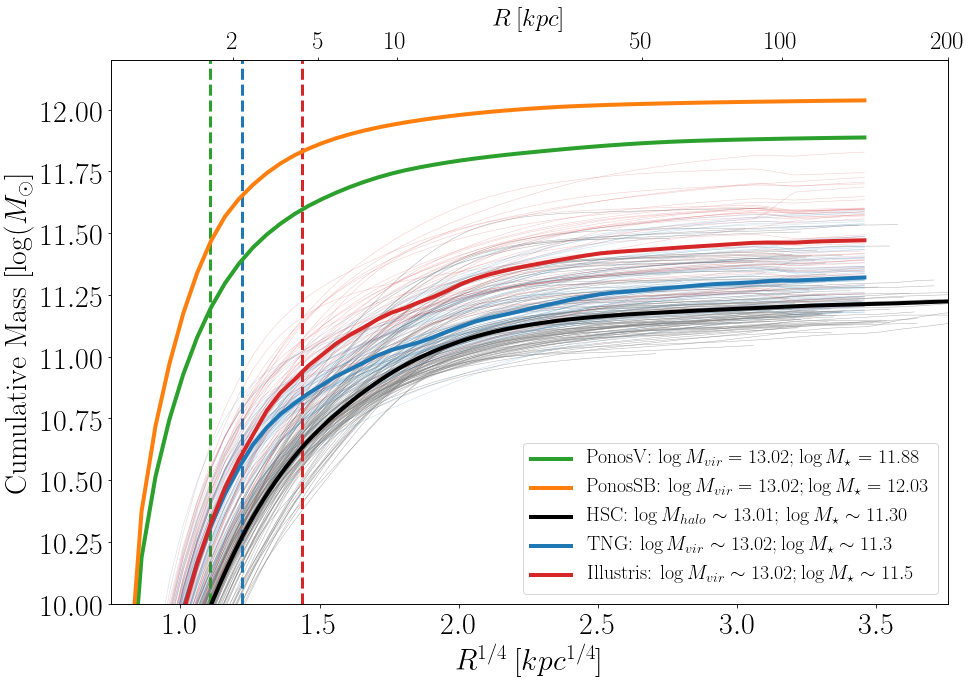

In [80]:
#mass range1
illustris_isos1=[]
ngals1=0

#plot
fig =plt.figure(figsize=(15, 10))
ax1 = plt.subplot()

radial_bins = np.arange(0.01, 3.5, 0.05)
 ######################################################################################################################
# plot
######################################################################################################################
# for iso in illustris_top_isos:   
    
#         illustris_isos1.append(iso)

#         ax1.plot((iso['sma'] * pixel_scale) ** 0.25,
#              np.log10(iso['intens'] / (pixel_scale**2.0))+ np.log10(0.7 ** 2.0) , linewidth=1.0, c=u'#d62728', alpha=0.2, 
#                  label='_nolegend_')
#                  #label='Illustris Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))

ax1.plot(radial_bins, 
         interp1d((V_iso['sma'] * pixel_scale) ** 0.25,np.log10(V_iso['growth_ori']) )(radial_bins),
         linewidth=4.0, alpha=1, c='#2ca02c', 
         label=r'PonosV: $ \log M_{vir} = 13.02; \log M_{\star}$ = '+str(round(V_masses[3],2)))
ax1.plot(radial_bins, 
         interp1d((SB_iso['sma'] * pixel_scale) ** 0.25,np.log10(SB_iso['growth_ori']) )(radial_bins),
         linewidth=4.0, alpha=1, c='#ff7f0e', 
         label=r'PonosSB: $ \log M_{vir} = 13.02; \log M_{\star}$ = '+str(round(SB_masses[3],2))) 


# ax1.plot((Q_iso['sma'] * pixel_scale) ** 0.25,
#      np.log10(Q_iso['intens'] / (pixel_scale**2.0))+ np.log10(0.7 ** 2.0) , linewidth=4.0, alpha=1, 
#          label=r'PonosQ: $ M_{halo} = 12.77; M_{\star}$ = '+str(Q_masses[0]))


## median profiles for illustris
# median_sma1, median_mu1 = get_median_profile(illustris_isos1, pixel_scale = pixel_scale)
# ax1.plot(median_sma1, median_mu1+ np.log10(0.7 ** 2.0), linewidth=4.0, c=u'#d62728', alpha=1, label='Illustris')

#hsc
plt.plot(sma_hsc, cumulative_isophote_masses, linestyle='-', linewidth=4.0, c='k',
         alpha=1, zorder=8, label='HSC: $ \log M_{halo} \sim 13.01$; $\log M_{\star} \sim 11.30$')
for profile in ponosv_all:
    plt.plot(sma_hsc, np.log10(np.cumsum(areas*(10**profile))), linestyle='-', linewidth=0.5, c='grey',
         alpha=0.6, zorder=1, label=None)
    
median = np.nanmedian(np.stack([np.log10(np.cumsum(areas*(10**profile))) for profile in ponosv_all]), axis=0)
# plt.plot(sma_hsc, median, linestyle='-', linewidth=4.0, c='orange',
#          alpha=1, zorder=8, label='HSC: $ \log M_{halo} \sim 13.01$; $\log M_{\star} \sim 11.30$')
for tng_iso in ponos_like_tng_isos:
    ax1.plot(radial_bins,
         interp1d((tng_iso['sma_kpc']) ** 0.25,np.log10(tng_iso['growth_ori']) )(radial_bins),
             linewidth=0.5, alpha=0.25, color =tng_color, label='_nolegend_' )
for illustris_iso in ponos_like_illustris_isos:
    if np.log10(illustris_iso['growth_ori'])[3] > 8: #ignore 1 weird profile
        ax1.plot(radial_bins,
         interp1d((illustris_iso['sma_kpc']) ** 0.25, np.log10(illustris_iso['growth_ori']) )(radial_bins),
                 linewidth=0.5, alpha=0.25, color =illustris_color,
                 label='_nolegend_' )

median_tng = get_median_profile(ponos_like_tng_isos,1, radial_bins, quantity='growth_ori')       
median_illustris = get_median_profile(ponos_like_illustris_isos,1, radial_bins, quantity='growth_ori')  

ax1.plot(radial_bins,
     median_tng , linewidth=4.0, alpha=1, color=tng_color,
         label='TNG: $\log M_{{vir}}\sim 13.02; \log M_{{\star}} \sim {0}$ '.format(mean_tng_m100)) 
ax1.plot(radial_bins,
     median_illustris , linewidth=4.0, alpha=1, color=illustris_color,
         label='Illustris: $\log M_{{vir}}\sim 13.02; \log M_{{\star}} \sim {0}$ '.format(mean_illustris_m100) )
######################################################################################################################
# plot details
######################################################################################################################
# # X-Y limits
ax1.set_xlim(0.75, 200**0.25)
ax1.set_ylim(10, 12.2)

ax1.tick_params(axis='both', which='major', labelsize=30)

#text label
# ax1.text(1.8, 4.5, r'$n = $ {:01.2E} Mpc$^{{-3}}$'.format(hsc_n), size=30)

ax1.legend(fontsize=20)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25])
ax1_twin.xaxis.set_ticklabels(["$2$", "$5$", "$10$", "$50$", "$100$", "$200$"])
ax1_twin.tick_params(axis='both', which='major', labelsize=25)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax1.set_ylabel(r'Cumulative Mass $[\log(M_{\odot} ]$', fontsize=30)
# ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
# ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=1, c='grey', zorder=1)
# ax1.fill_between([0,6.0 ** 0.25],[4,4], [13,13], color='grey', alpha =0.2)

ax1.axvline(1.5 ** 0.25, linestyle='--', linewidth=3.0, alpha=1, c='#2ca02c', zorder=1)
ax1.axvline((0.74*3) ** 0.25, linestyle='--', linewidth=3.0, alpha=1, c=tng_color, zorder=1)
ax1.axvline((1.42*3) ** 0.25, linestyle='--', linewidth=3.0, alpha=1, c=illustris_color, zorder=1)
# ax1.axvline(2.1 ** 0.25, linestyle=':', linewidth=3.0, alpha=1, c=illustris_color, zorder=1)
######################################################################################################################

fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/cumulative_mass_profile.pdf',
            dpi=100, format='pdf', bbox_inches='tight')

plt.show()

cant include HSC because I dont have ellipticity info

## how to plot curve of growth: no h factors of pixel scale necessary 

In [20]:
def oneD_mass_test(galaxy_iso, radius_kpc):
    """radius in kpc"""
    radius_px = radius_kpc/pixel_scale_from_iso(galaxy_iso)
    mass_without_anything=np.interp(radius_px,galaxy_iso['sma'], 
                                    galaxy_iso['growth_ori'])
    mass_with_pixel_scale=np.interp(radius_px,galaxy_iso['sma'], 
                                    galaxy_iso['growth_ori']/(pixel_scale_from_iso(galaxy_iso)**2.0))
    mass_with_h=np.interp(radius_px,galaxy_iso['sma'], 
                          galaxy_iso['growth_ori']*(0.7**2))
    mass_with_h_and_pixel_scale=np.interp(radius_px,galaxy_iso['sma'],
                                          galaxy_iso['growth_ori']*(0.7**2)/(pixel_scale_from_iso(galaxy_iso)**2.0))
    return np.log10([mass_without_anything, mass_with_pixel_scale, mass_with_h, mass_with_h_and_pixel_scale])

In [21]:
print(oneD_mass_test(V_iso,100))
print(V_masses[-2]) #2d 100


[11.88221989 12.09663983 11.57241597 11.78683591]
11.915694918542343


In [22]:
print(oneD_mass_test(SB_iso,100))
print(SB_masses[-2]) #2d 100

[12.03330573 12.24772567 11.72350181 11.93792175]
12.031186275664622


In [23]:
print(oneD_mass_test(V_iso,30))
print(V_masses[-3]) #2d 30

[11.83599739 12.05041733 11.52619347 11.74061341]
11.870531487258383
